# Predicting Forest Fires


In this notebook I will explore different machine learning regression algorithms to see how well they can predict forest fire outcomes. In this notebook I will examine the different merits and drawbacks of using multiple linear regression, polynomial regression, SVM regression, and random forest regression.


All X features are scaled and y has been transformed.

# Model

I will perform a series of operations on this dataset to understand the different pros and cons of each type of regression algorithm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Import data from flat file

# Set path
path = 'DRV_ForestFires.csv'
data = pd.read_csv(path)
data.head()

X_train = pd.read_csv('DRV_ForestFires_XTrain.txt').values
X_test = pd.read_csv('DRV_ForestFires_XTest.txt').values
y_train = pd.read_csv('DRV_ForestFires_yTrain.txt').values
y_test = pd.read_csv('DRV_ForestFires_yTest.txt').values

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Multiple Linear Regression with Backwards Elimination

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.formula.api as sm

In [24]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1, )
selector = selector.fit(X_train, y_train)

opt = selector.get_support()

OLS = sm.OLS(y_train, X_train[:, opt]).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     15.76
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           1.02e-09
Time:                        12:40:28   Log-Likelihood:                -811.85
No. Observations:                 413   AIC:                             1630.
Df Residuals:                     410   BIC:                             1642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1854      0.087      2.135      0.033       0.015       0.356
x2             0.2085      0.087      2.396      0.017       0.037       0.380
x3             1.3564      0.217      6.252      0.000       0.930       1.783
==============================================================================
Omnibus:                       44.282   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.435
Skew:                           0.863   Prob(JB):                     9.17e-13
Kurtosis:                       3.491   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the OLS regression formula the maximum Adjusted R-Squared value is reached when there are 19 features included in the regression equation. While that may produce the highest R-squared value, that model will almost certainly not withstand the test set since it likely falls victim to overfitting on a considerable scale.

In [25]:
data.drop('area', axis=1).columns[opt]

Index(['DMC', 'wind', 'day_sat'], dtype='object')

The above columns are the ones selected by the model as regressors. This list makes some sense to me. Fires are more likely to continue burning in the hotter drier months, and increased traffic in the forest on Saturdays is likely to correlate with higher occurence of fires. Still I have trouble beleiving that these three factors alone are the best we can do.

In [26]:
selector.score(X_test, y_test)

-0.0986325789471365

As we see, this model is completely broken when it evaluates the test data. Even though the model only has three inputs, it still is guilty of overfitting the training set and in the end models the test set worst than a model that makes random correlations.

## Mulitple Linear Regression with Recursive Feature Elimination with Cross Validation

Performs the same Backwards Elimination, but has the added complexity of incorporating cross validation. Cross Validation is the process of splitting the training data into smaller subsets. The model finds parameters for each of the subsets.

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score

In [28]:
estimator = LinearRegression()
selector = RFECV(estimator, min_features_to_select=3, cv=5, step=1, scoring='r2')
selector = selector.fit(X_train, y_train)

opt = selector.get_support()

OLS = sm.OLS(y_train, X_train[:, opt]).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     10.56
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           1.50e-09
Time:                        12:40:40   Log-Likelihood:                -809.26
No. Observations:                 413   AIC:                             1629.
Df Residuals:                     408   BIC:                             1649.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0881      0.117      0.750      0.454      -0.143       0.319
x2             0.1710      0.122      1.400      0.162      -0.069       0.411
x3            -0.1409      0.087     -1.625      0.105      -0.311       0.030
x4             0.2476      0.089      2.795      0.005       0.073       0.422
x5             1.3452      0.216      6.221      0.000       0.920       1.770
==============================================================================
Omnibus:                       42.340   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.397
Skew:                           0.842   Prob(JB):                     4.19e-12
Kurtosis:                       3.454   Cond. No.                         3.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
data.drop('area', axis=1).columns[opt]

Index(['DMC', 'DC', 'RH', 'wind', 'day_sat'], dtype='object')

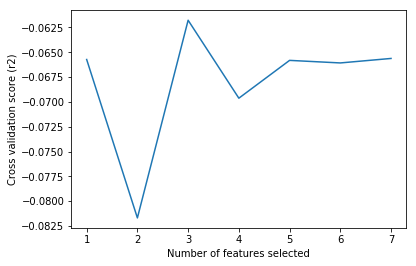

In [30]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

Model is garbage. Predicts slightly better than random at its best.

## Multiple Linear Regression with F_Regression

In [31]:
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile

In [41]:
estimator = LinearRegression()
selector = SelectPercentile(f_regression, percentile=30)
selector.fit(X_train, y_train)

opt = selector.get_support()

OLS = sm.OLS(y_train, X_train[:, opt]).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.308
Date:                Thu, 07 Mar 2019   Prob (F-statistic):             0.0202
Time:                        12:42:12   Log-Likelihood:                -829.45
No. Observations:                 413   AIC:                             1665.
Df Residuals:                     410   BIC:                             1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0564      0.122      0.462      0.644      -0.183       0.296
x2             0.1969      0.127      1.548      0.122      -0.053       0.447
x3             0.2113      0.092      2.288      0.023       0.030       0.393
==============================================================================
Omnibus:                       78.502   Durbin-Watson:                   1.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.962
Skew:                           1.210   Prob(JB):                     5.41e-27
Kurtosis:                       4.082   Cond. No.                         2.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
data.drop('area', axis=1).columns[opt]

Index(['DMC', 'DC', 'wind'], dtype='object')

# Visualize

In [17]:
# import matplotlib.pyplot as plt
# import seaborn as sns

In [16]:
# # Plot Training data
# plt.scatter(X_train, y_train, color='red')
# sns.regplot(X_train, regressor.predict(X_train), color='blue')
# plt.title('Training Parameters')
# plt.show()

In [15]:
# # Plot Test data
# plt.scatter(X_test, y_test, color='red')
# sns.regplot(X_test, regressor.predict(X_test), color='blue')
# plt.title('Test Parameters')
# plt.show()